In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

#обработка
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# модели
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

# метрики качества модели
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

# улучшение модели
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from yellowbrick.model_selection import LearningCurve

In [ ]:
df = pd.read_csv('final.csv')
df.head()

,class,av_flat,min_ceiling_h,parking_ratio,infr_access,lift_ratio
0,Типовой,44.460000,2.70,0.000000,5,0.000000
1,Комфорт,69.358974,2.95,1.426282,8,46.800000
2,Комфорт,37.243697,2.70,1.878151,8,69.133333
3,Комфорт,40.970794,2.72,0.964953,5,72.004706
4,Комфорт,40.695195,2.72,1.040541,6,70.027941


# Итоговый план по машинному обучению:

- Предсказываем категориальную переменную ‘class’ - класс недвижимости, принимающий значения {'Типовой', 'Комфорт', 'Бизнес', 'Элитный'}. Будет мультиклассовое предсказание, так как у нас есть 4 различных класса.
- Задача: по совокупности категориальных и дейсвительных признаков определить класс недвижимости (задача классификации)
- Разделить данные на признаки (x)  и целевую переменную (y)
- Разделить выборку в соотношении 80/20 - треин/тест
- Использовать кросс-валидацию
- Если выборки не хватает: SMOTE (овэрсемплинг)

## Модели, которые будем рассматривать при кросс-валидации:


- **Логистическая регрессия** - хорошо работает с бинарными и многоклассовыми классификациями (может обучать K моделей, каждая из которых отличается только целевым классом)
-**Наивный байес (категориальный и гауссовский)** - простой и эффективный классификатор, который хорошо подходит для категориальных данных. Легко справляется с большими объёмами данных. Он может использоваться для мультиклассовой классификации, но предполагает независимость признаков, что может быть ограничением в некоторых случаях
- **Метод опорных векторов без ядра и с гауссовским ядром** - эффективен для классификации с использованием различных ядер. Однако при использовании гауссовского ядра SVM может столкнуться с проблемами масштабирования
- **Случайный лес** - хорошо работает с большим количеством признаков и способна обрабатывать как категориальные, так и числовые признаки
- **Градиентный бустинг, Catboost,** может давать хорошие результаты для мультиклассовой классификации. Они могут быть эффективными моделями, особенно при настройке оптимальных параметров

**Модель, которую мы изначально хотели рассматривать, но отказались от них:**

- **KNN** - может использоваться для предсказания категориальных переменных, но плохо работает с большими объемами данных, так как может быть вычислительно затратным при большом количестве признаков (требует вычисления расстояний до всех обучающих примеров), склонен к смещению решения в сторону доминирующего класса.

##Метрики

1. **Матрица ошибок (Сonfusion matrix)** - матрица, которая показывает сколько объектов каждого класса были распознаны правильно, а сколько - неправильно. На основе матрицы ошибок и её значений, рассчитываются различные метрики классификационной способности алгоритма. Дает наглядно понять, как хорошо работает модель.
2. **Меткость (Accuracy)** - доля правильно предсказанных классов. Характеризует качество модели, но зачастую используется в сочетании с другими метриками. Данная метрика часто используется в задачах классификации, когда все классы равноправны и одинаково важны, и нет явного дисбаланса классов. (Так как у нас присутствует дисбаланс классов, то мы все равно посчитаем эту метрику, но не будем опираться на нее при оценке модели)
3. **Точность (Precision)** -это метрика оценки качества модели в задачах классификации, которая измеряет долю правильно предсказанных положительных классов относительно всех объектов, которые модель предсказала как положительные. Другими словами, точность дает ответ на вопрос «Из всех объектов, которые классифицированы как принадлежащие классу, сколько на самом деле принадлежит ему?». Наиболее часто используеься когда присутствует дисбаланс классов (поэтому обратим на нее особое внимание).
4. **Полнота (Recall)** - пропорция всех верно-положительно предсказанных объектов к общему количеству действительно положительных. То есть, полнота показывает сколько образцов из всех положительных примеров были классифицированы правильно. Наиболее часто используеься когда присутствует дисбаланс классов (поэтому обратим на нее особое внимание).
5. **F1-мера (F1-score)** - взвешенное гармоническое среднее полноты и точности. Этот показатель демонстрирует, как много случаев прогнозируется моделью правильно, и сколько истинных экземпляров модель не пропустит.
6. **Площадь под ROC-кривой (Area under ROC-curve, AUC-ROC)** - это метрика, используемая в задачах классификации для измерения площади под кривой receiver operating characteristic (ROC). Она оценивает компромисс между частотой истинных и ложных положительных результатов при различных пороговых значениях классификации.
7. **Площадь под кривой полнота-точность (Area under precision-recall curve, AUC-PR)** - это метрика, используемая в задачах классификации для измерения площади под кривой "precision-recall". Она обеспечивает комплексную оценку эффективности модели на различных уровнях precision и recall при различных пороговых значениях классификации. Используется, когда необходимо оценить эффективность модели классификации при различных компромиссах между precision и recall и выбрать оптимальное значение порога. Он особенно полезен, когда есть дисбаланс классов.


Таким образом, основными метриками, на которых мы сконцентрируемся будут Precision, Recall и F1-score, так как они хорошо работают при дисбалансе классов.

#Машинное обучение

## Разделение переменных

Разделим данные на признаки X и целевую переменную y.

In [ ]:
X = df.drop(['class'], axis=1)
X.head()

,av_flat,min_ceiling_h,parking_ratio,infr_access,lift_ratio
0,44.460000,2.70,0.000000,5,0.000000
1,69.358974,2.95,1.426282,8,46.800000
2,37.243697,2.70,1.878151,8,69.133333
3,40.970794,2.72,0.964953,5,72.004706
4,40.695195,2.72,1.040541,6,70.027941


In [ ]:
y = df['class']
y.head()

0    Типовой
1    Комфорт
2    Комфорт
3    Комфорт
4    Комфорт
Name: class, dtype: object

## Деление выборки и SMOTE

Разделим выборку случайным образом в соотношении 80/20, где 80% строк выделяется для тренировочной выборки, а 20% - для тестовой.  

У нас есть явный дисбаланс классов, поэтому мы обязательно будем использовать кросс-валидацию. Кроме того, выборки может не хватить и случайное ее разделение не очень хорошо подходит, поэтому можно искусственно увеличить ее за счет, например, метода SMOTE.

In [ ]:
y.value_counts()

class
Комфорт    5038
Типовой    2581
Бизнес      785
Элитный     212
Name: count, dtype: int64

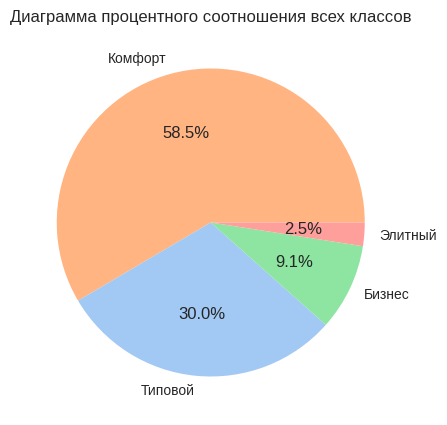

In [ ]:
fig, ax = plt.subplots(figsize = (5, 5))
colors = ['#FFB482', '#A1C9F4', '#8DE5A1', '#FF9F9B']
ax.pie(list(y.value_counts()), labels=y.value_counts().index, colors=colors, autopct='%1.1f%%')
ax.set(title = 'Диаграмма процентного соотношения всех классов')
plt.show()

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, stratify = y_smote, random_state = 42)
X_train.shape, X_test.shape

((16121, 5), (4031, 5))

In [ ]:
p = list(np.unique(y_train, return_counts=True))
p.append(np.unique(y_test, return_counts=True)[1])
pd.DataFrame(np.array(p).T, columns = ['class', 'train', 'test'])

,class,train,test
0,Бизнес,4030,1008
1,Комфорт,4031,1007
2,Типовой,4030,1008
3,Элитный,4030,1008


In [ ]:
y_smote.value_counts()

class
Типовой    5038
Комфорт    5038
Бизнес     5038
Элитный    5038
Name: count, dtype: int64

Проскалируем данные

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
X_train

array([[0.23363134, 0.32653061, 0.03894797, 0.66666667, 0.3507047 ],
       [0.14964933, 0.47933118, 0.13264501, 0.77777778, 0.32312696],
       [0.0840435 , 0.08163265, 0.11776576, 0.22222222, 0.        ],
       ...,
       [0.09090645, 0.30204082, 0.40333135, 0.        , 0.53366641],
       [0.15676011, 0.33449155, 0.15160296, 0.77777778, 0.17039388],
       [0.05787682, 0.30204082, 0.10764634, 0.77777778, 0.17732244]])

In [ ]:
X_test

array([[0.12276824, 0.24489796, 0.12985778, 0.55555556, 0.        ],
       [0.14362841, 0.21005823, 0.22965465, 0.66666667, 0.2127184 ],
       [0.14173618, 0.13061224, 0.06760061, 0.44444444, 0.40232265],
       ...,
       [0.13055332, 0.24489796, 0.06962425, 0.33333333, 0.57312085],
       [0.14450523, 0.21607684, 0.17083819, 0.66666667, 0.19319023],
       [0.04042024, 0.24489796, 0.12704353, 0.        , 0.26735336]])

## Выбор модели

Проведем сравнение нескольких моделей с помощью кросс-валидации. Для сравнения будем использовать следующие модели:  


1. Модель логистической регрессии (LogisticRegression);
2. Метод опорных векторов без ядра (SVC(kernel = "linear"));
3. Метод опорных векторов с гауссовским ядром (SVC(kernel = "rbf"));
4. Гауссовский Наивный Байес (GaussianNB);
5. Категориальный Наивный Байес (CategoricalNB);
6. Случайный лес (RandomForestClassifier);
7. Градиентный бустинг (GradientBoostingClassifier);
8. CatBoost (CatBoostClassifier).

In [ ]:
classifiers = {"Logistic Regression": LogisticRegression(max_iter = 2000),
               "Linear SVM": SVC(kernel = "linear"),
               "RBF SVM": SVC(kernel = "rbf"),
               "Gaussian Naive Bayes": GaussianNB(),
               "Categorical Naive Bayes": CategoricalNB(),
               "Random Forest": RandomForestClassifier(),
               "Gradient Boosting": GradientBoostingClassifier(),
               'CatBoost': CatBoostClassifier(verbose = False)}

In [ ]:
scores = {}

for name, clf in classifiers.items():
    cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring='f1_macro', return_train_score = True)

    scores[name] = [cv_results['test_score'].mean(), cv_results['train_score'].mean(), cv_results['fit_time'].mean()]

In [ ]:
df_cross_val = pd.DataFrame(scores, index = ['test_score', 'train_score', 'fit_time']).T
df_cross_val.sort_values(by = ['test_score'], ascending = False, inplace = True)
df_cross_val

,test_score,train_score,fit_time
Random Forest,0.885629,0.999659,2.612691
CatBoost,0.872914,0.940098,12.976030
Gradient Boosting,0.804948,0.823816,10.622377
RBF SVM,0.664604,0.668975,4.925158
Logistic Regression,0.597906,0.598486,0.199257
Linear SVM,0.593356,0.593208,4.621633
Gaussian Naive Bayes,0.544917,0.546145,0.025355
Categorical Naive Bayes,0.149256,0.149289,0.053656


Среди всех моделей лучший результат показала модель Random Forest, но есть признаки переобучения. Дальше поработаем именно с этой моделью.

## Сравнение моделей

### Random Forest

#### **Кривая обучения**

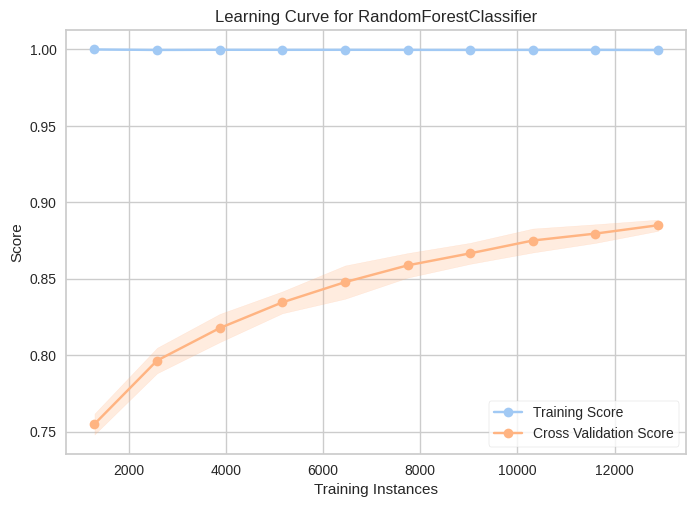

In [ ]:
model = RandomForestClassifier()
visualizer = LearningCurve(model, train_sizes=np.linspace(0.1, 1.0, 10)).fit(X_train, y_train).show()

Как и было предположено раньше, по графику кривой обучения видно, что у модели присутствуют признаки переобучения.

#### **Подбор гиперпараметров**

In [ ]:
params_rf = {'n_estimators': [10, 50, 100, 500],
             'max_depth': [None, 5, 10, 50, 100],
             'min_samples_split': [2, 5, 10]
}

grid_model_rf = GridSearchCV(estimator=model, param_grid=params_rf, scoring='f1_macro', cv=5, return_train_score=True)

grid_model_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10, 50, 100],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 500]},
             return_train_score=True, scoring='f1_macro')

In [ ]:
cv_info = pd.DataFrame(grid_model_rf.cv_results_)[['params', 'mean_test_score', 'mean_train_score', 'rank_test_score']]
cv_info.sort_values(by = 'rank_test_score', ascending = True, inplace = True)
cv_info.head()

,params,mean_test_score,mean_train_score,rank_test_score
51,"{'max_depth': 100, 'min_samples_split': 2, 'n_...",0.886460,0.999659,1
3,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.886101,0.999659,2
2,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.885700,0.999659,3
39,"{'max_depth': 50, 'min_samples_split': 2, 'n_e...",0.885641,0.999659,4
50,"{'max_depth': 100, 'min_samples_split': 2, 'n_...",0.885466,0.999659,5


In [ ]:
best_params = dict(cv_info.loc[3].params)
pd.DataFrame(best_params.values(), index = best_params.keys(), columns = ['Лучшие параметры'])

,Лучшие параметры
max_depth,NaN
min_samples_split,2.0
n_estimators,500.0


#### **Метрики**

In [ ]:
best_model_rf = grid_model_rf.best_estimator_
best_model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=500)

In [ ]:
y_pred = best_model_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred)
pr_rf = precision_score(y_test, y_pred, average = 'macro')
rc_rf = recall_score(y_test, y_pred, average = 'macro')
f1_rf = f1_score(y_test, y_pred, average = 'macro')

metrics_rf = pd.DataFrame({'Random Forest': [acc_rf, pr_rf, rc_rf, f1_rf]}, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
metrics_rf

,Random Forest
Accuracy,0.883900
Precision,0.884413
Recall,0.883885
F1,0.883998


Построим матрицу ошибок для лучшего понимания того, какие классы модель предсказывает правильно:

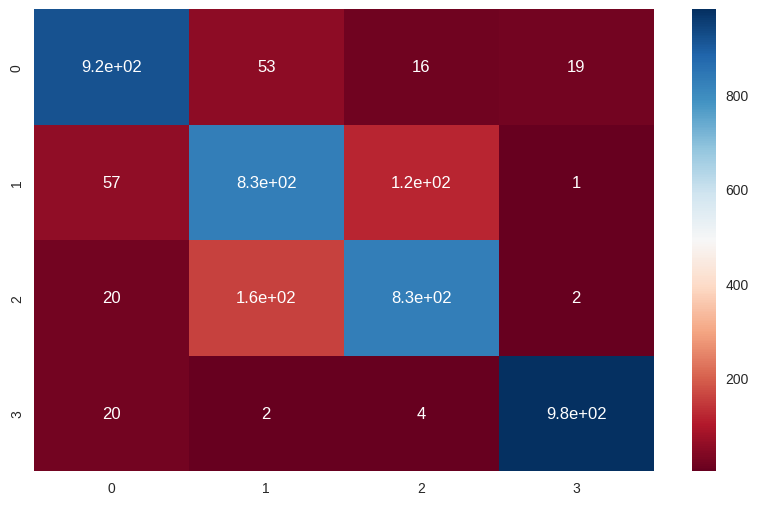

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="RdBu", annot = True)
plt.show()

Можно сказать, что модель неплохо справляется с предсказыванием класса, ошибок не так много.

Проанализируем кривые ROC-AUC и PR-AUC:

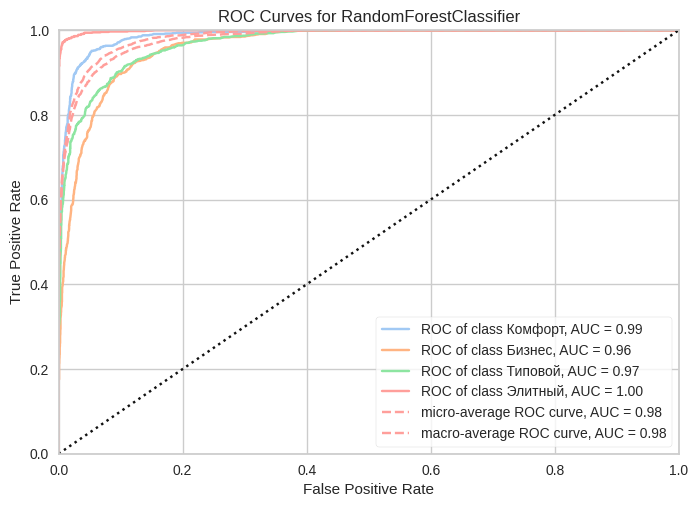

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
cls = pd.unique(y_train)
visualizer_roc = ROCAUC(best_model_rf, classes = cls)
visualizer_roc.fit(X_train, y_train)
visualizer_roc.score(X_test, y_test)
visualizer_roc.show()

На графике ROC кривых представленны кривые и метрики для каждого из четырех классов. Так как данный показатель применим только к бинарной классификации, алгоритм рассчитывает метрики для каждого класса, обозначая нужный класс за 0, а остальные за 1, тем самым приводя к бинарной классификации.

Показатель AUC−ROC является мерой качества классификатора относительно идеального. Значение показателя в пределах [0.95, 1] говорит о хорошем качестве модели.

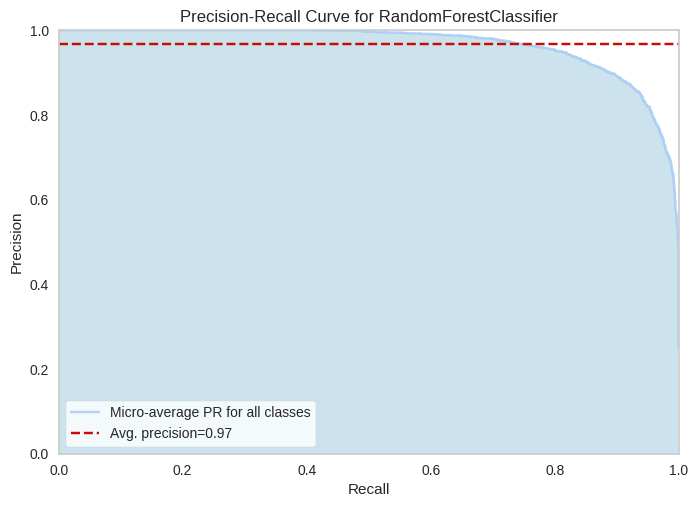

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
visualizer_pr = PrecisionRecallCurve(best_model_rf, classes = cls)
visualizer_pr.fit(X_train, y_train)
visualizer_pr.score(X_test, y_test)
visualizer_pr.show()

PR-AUC - метрика, отражает качество классификатора и позволяет сравнивать кривые, соответствующие различным балансам классов и значениям порога. Чем больше площадь, тем лучше работает модель. В данном случае метрика равна 0.97, что говорит о хорошем качестве модели.

#Вывод

Таким образом, RandomForest достаточно хорошо справляется с предсказыванием класса. Такой вывод мы сделали, проведя кросс-валидацию (где выбрали лучшую модель) и подобрав лучшие параметры.